# B-LDA

In [1]:
library(ggplot2)
library(RcppArmadillo)
library(reshape2)
library(Rcpp)
library(Matrix)
library(dplyr)
library(stringr)
library(ROCR)
source("/Users/kosuke/thesis/airport_thesis/code/utils/calc_lda_param.R")
source("/Users/kosuke/thesis/airport_thesis/code/utils/hold-out.R")
sourceCpp("/Users/kosuke/thesis/airport_thesis/code/lda/lda_bernoulli.cpp")
options(warn=-1)
options(scipen=10)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [2]:
data <- read.csv("/Users/kosuke/thesis/airport_thesis/data/recommend.csv", stringsAsFactors=F)
train_corpus <- read.csv("/Users/kosuke/thesis/airport_thesis/data/train_corpus.csv")
test_corpus <- read.csv("/Users/kosuke/thesis/airport_thesis/data/test_corpus.csv")

bound <- min(test_corpus[,2])
test_y <- data[bound:nrow(data),]
test_y <- as.vector(sapply(test_y, replace_y, "no"))

train_corpus <- as.matrix(train_corpus)
train_corpus <- cbind(train_corpus, 1)


set.seed(1234)
x <- rbinom(length(test_y),1, sum(test_y)/length(test_y))
tag <- data.frame(doc_index=seq(max(train_corpus[,2]) + 1, 7437), tag_index=x)
tag_random <- inner_join(test_corpus, tag, by="doc_index")[,5]
test_corpus[,4] <- tag_random
test_corpus <- as.matrix(cbind(test_corpus, 0))

corpus <- rbind(train_corpus, test_corpus)

V <- max(corpus[,1])
D <- max(corpus[,2])

In [3]:
t <- proc.time()
k <- 10
it = 0
alpha   <- 0.1
beta    <- 0.1

LL <- as.vector(NULL)
WL <- as.vector(NULL)
YL <- as.vector(NULL)
burn_in = 1000
total = 2000
res <- list()
for(i in k){
    gamma   <- 0.1 * nrow(corpus)/i
    it = it + 1
    set.seed(1234)
    res[[it]] <- BLDAcgs(corpus, i, alpha, beta, gamma, total, burn_in, 1, 0, 0)
    LL[it] <- burn_in / (sum(1 / res[[it]]$likelihood[(burn_in + 1):total]))
}
proc.time() - t


   user  system elapsed 
331.809   2.018 340.717 

In [4]:
y <- apply(res[[1]]$y[(nrow(train_corpus)+1):nrow(corpus), ], 1, function(x){
    return (which(x == max(x)) - 1)
})
result <- cbind(test_corpus, unlist(y))
y_pred <- NULL
y_prop_deter <- NULL
for(d in (bound):max(test_corpus[,2])){
    res_d <- result[result[,2] == d, ]
    y_prop_deter[d - (bound - 1)] <- mean(res_d[, 6])
    if(mean(res_d[, 6]) <= 0.5){
        y_pred[d - (bound - 1)] <- 0
    }
    else{
        y_pred[d - (bound - 1)] <- 1
    }
}
accuracy_deter <- calc_accuracy(y_pred, test_y)

#### B-LDA crisp

In [5]:
accuracy_deter

TRUE 
0.8010753

In [6]:
table(y_pred, test_y)

      test_y
y_pred   0   1
     0 450  93
     1  55 146

In [7]:

pred     <- prediction(y_prop_deter, test_y)
auc.temp <- performance(pred, "auc")
auc   <- unlist(auc.temp@y.values)
auc

[1] 0.8238908

#### B-LDA prob

In [8]:
pred_y <- res[[1]]$y[(nrow(train_corpus)+1):nrow(corpus), ]
y_prop <- apply(data.frame(pred_y), 1, function(x){
    return (x[2] / 1000)
})

result <- cbind(test_corpus, y_prop)
y_pred <- NULL
y_prop <- NULL
for(d in (bound):max(test_corpus[,2])){
    res_d <- result[result[,2] == d, ]
    y_prop[d - (bound - 1)] <- mean(res_d[, 6])
    if(mean(res_d[, 6]) <= 0.5){
        y_pred[d - (bound - 1)] <- 0
    }
    else{
        y_pred[d - (bound - 1)] <- 1
    }
}
accuracy_prob <- calc_accuracy(y_pred, test_y)

In [9]:
accuracy_prob

TRUE 
0.858871

In [11]:
table(y_pred, test_y)

      test_y
y_pred   0   1
     0 464  64
     1  41 175

In [12]:
pred     <- prediction(y_prop, test_y)
auc.temp <- performance(pred, "auc")
auc   <- unlist(auc.temp@y.values)
auc

[1] 0.9068023

#### MPQA

In [20]:
sum(table(pol_mpqa, test_y)[c(1,4)]) / length(test_y)

[1] 0.7647849

In [21]:
table(pol_mpqa, test_y)

        test_y
pol_mpqa   0   1
       0 375  45
       1 130 194

In [22]:
pred     <- prediction(mpqa_prop, test_y)
auc.temp <- performance(pred, "auc")
auc   <- unlist(auc.temp@y.values)
auc

[1] 0.8461394

Saving 7 x 7 in image


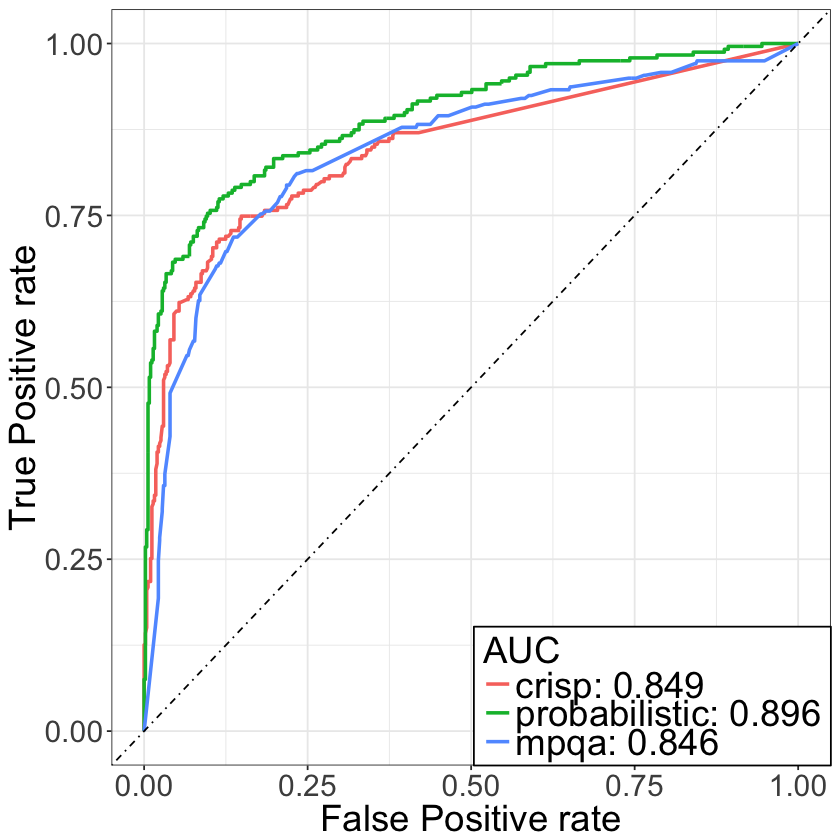

In [36]:
mat <- NULL
pred     <- prediction(y_prop_deter, test_y)
perf <- performance(pred, "tpr", "fpr")
mat <- rbind(mat, data.frame(AUC="crisp: 0.849", FP=unlist(perf@x.values), TP=unlist(perf@y.values)))

pred     <- prediction(y_prop, test_y)
perf <- performance(pred, "tpr", "fpr")
mat <- rbind(mat, data.frame(AUC="probabilistic: 0.896", FP=unlist(perf@x.values), TP=unlist(perf@y.values)))

pred     <- prediction(mpqa_prop, test_y)
perf <- performance(pred, "tpr", "fpr")
mat <- rbind(mat, data.frame(AUC="mpqa: 0.846", FP=unlist(perf@x.values), TP=unlist(perf@y.values)))

p <- ggplot(mat, aes(x=FP, y=TP, group=AUC, colour=AUC))
p <- p + geom_line(size=1)
p = p + theme_bw()
p <- p + geom_abline(intercept=0,slope=1, linetype=4) 
p <- p + xlim(0, 1)
p <- p + theme(legend.position=c(1, 0), legend.justification=c(1, 0))
p <- p + theme(legend.background=element_rect(fill="white", colour="black"))
p <- p + theme(legend.title=element_text(size=22), legend.text=element_text(size=22))
p <- p + xlab("False Positive rate") + ylab("True Positive rate")
p <- p + theme(
            axis.title.x = element_text(size = 22),
            axis.title.y = element_text(size = 22),
            axis.text.x = element_text(size = 18),
            axis.text.y = element_text(size = 18))
p
ggsave(file="/Users/kosuke/thesis/airport_thesis/report/auc.pdf", plot=p)

## Topic Extraction

In [34]:
K <- 11
vocab <- read.csv("/Users/kosuke/thesis/airport_thesis/data/mid/corpus/train_vocab.csv")[,1]
topwords <- calc_topwords(t(res[[K]]$phi), vocab, k[K], 10)

#### 分布

In [35]:
psi <- data.frame(k=1:150, psi=res[[11]]$psi)
p <- ggplot(psi, aes(x=psi))
p <- p + geom_histogram()
p = p + xlab("psi") + ylab("freq")
p = p + theme_bw()
p <- p + theme(
            axis.title.x = element_text(size = 15),
            axis.title.y = element_text(size = 15),
            axis.text.x = element_text(size = 12),
            axis.text.y = element_text(size = 12))
ggsave(file="/Users/kosuke/thesis/airport_thesis/pic/histo_psi.pdf", plot=p)

Saving 7 x 7 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


#### 上位10単語

In [39]:
psi <- data.frame(k=1:150, psi=res[[11]]$psi)
pos_topwords <- topwords[,psi$psi > 0.66]
colnames(pos_topwords) <- psi[psi$psi > 0.66,]$k
pos_topwords_paste <- data.frame(words= apply(pos_topwords, 2, function(x){
    return (paste(x, collapse = ", "))
}))
write.csv(pos_topwords_paste, "pos_topwrods.csv")

In [44]:
neg_topwords <- topwords[,psi$psi < 0.33]
colnames(neg_topwords) <- psi[psi$psi < 0.33,]$k

neg_topwords_paste <- data.frame(words= apply(neg_topwords, 2, function(x){
    return (paste(x, collapse = ", "))
}))
write.csv(neg_topwords_paste, "neg_topwrods.csv")

In [54]:
psi[psi$psi>0.66,]

,k,psi
4,4,0.7132318
68,68,0.7415937
85,85,0.9955511
92,92,0.9946750


In [56]:
psi[psi$psi<0.33,]

,k,psi
1,1,0.004820486
7,7,0.025309658
21,21,0.005728949
59,59,0.011205931
70,70,0.006524865
93,93,0.206150616
112,112,0.038525895
135,135,0.010570313


#### コーパス長

In [174]:
nrow(train_corpus)

[1] 329454

In [175]:
nrow(test_corpus)

[1] 40647

#### 語彙数

In [179]:
length(unique(train_corpus[,1]))

[1] 12006

In [178]:
length(unique(test_corpus[,1]))

[1] 4545

## polarity dictionary

In [37]:
est_p_v <- function(phi, psi){
    numerator <- phi %*% psi
    denominator <- apply(phi, 1, sum)
    return (numerator / denominator)
}

In [38]:
p_v <- data.frame(word_index=1:V, p_v=est_p_v(res[[11]]$phi, res[[11]]$psi))
p_v$polarity <- 0
p_v[p_v$p_v > 0.5, ]$polarity <- "positive"
p_v[p_v$p_v <= 0.5, ]$polarity <- "negative"

In [39]:
vocab_mat <- inner_join(mpqa, p_v, by="word_index")
sum(table(vocab_mat$polarity.x, vocab_mat$polarity.y)[c(1,4)]) / nrow(vocab_mat)

pred     <- prediction(vocab_mat$p_v, vocab_mat$polarity.x)
auc.temp <- performance(pred, "auc")
auc   <- unlist(auc.temp@y.values)
auc

[1] 0.6023041

[1] 0.640873

In [40]:
nrow(vocab_mat)

[1] 2170

Saving 7 x 7 in image


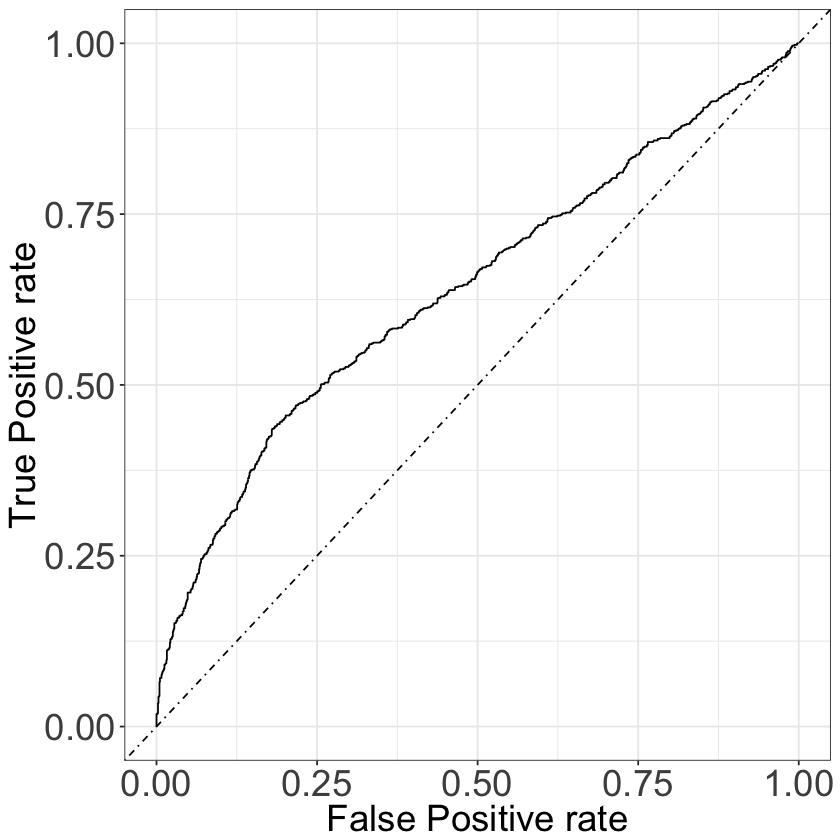

In [41]:
pred     <- prediction(vocab_mat$p_v, vocab_mat$polarity.x)
perf <- performance(pred, "tpr", "fpr")
mat <- data.frame(FP=unlist(perf@x.values), TP=unlist(perf@y.values))
p <- ggplot(mat, aes(x=FP, y=TP))
p <- p + geom_line()
p = p + theme_bw()
p <- p + geom_abline(intercept=0,slope=1, linetype=4) 
p <- p + xlim(0, 1)

p <- p + xlab("False Positive rate") + ylab("True Positive rate")
p <- p + theme(
            axis.title.x = element_text(size = 22),
            axis.title.y = element_text(size = 22),
            axis.text.x = element_text(size = 22),
            axis.text.y = element_text(size = 22))
p
ggsave(file="/Users/kosuke/thesis/airport_thesis/report/polarity_dic_roc.pdf", plot=p)